# Case study

In [1]:
from colorama import Fore
import numpy as np
import pandas as pd
import re
import sys
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
DATADIR = "../usb/releases/20201018/"
DROPOUTDATADIR = "../usb/releases/20200302/"
CLIENTSFILE = "clients.csv.gz"
DROPOUTFILE = "dropout.csv.gz"
ANSWERID = "answerId_normalized"
ANSWERIDORIGINAL = "answerId_original"
ANSWERTEXT = "answerText"
ANSWERTITLE = "answerTitle"
CLIENT = "client"
CLIENTID = "clientID"
DROPOUT = "dropout"
QUESTIONNUMBER = "questionNumber"
REMOVED = "REMOVED"
COMPLETERCODE = "2"
DROPOUTCODE = "1"

In [3]:
def read_dropout_ids():
    dropout = pd.read_csv(DROPOUTDATADIR+DROPOUTFILE)
    dropout_ids = list(dropout[dropout[DROPOUT]==DROPOUTCODE][CLIENTID])
    completer_ids = list(dropout[dropout[DROPOUT]==COMPLETERCODE][CLIENTID])
    return(dropout_ids,completer_ids)

In [4]:
dropout_ids,completer_ids = read_dropout_ids()
len(dropout_ids),len(completer_ids)

(653, 359)

## Task 1: compare metadata of dropouts and completers

In [5]:
GENDER = "geslacht"
AGE = "leeftijd"
EDUCATION = "opleidng"
DAY1 = "dag1"
MAN = "Man"
WOMAN = "Vrouw"
ANSWER = "answer"
COUNT = "count"
YESNO = "YESNO"
YESNOIDS = ["dagritme","dsm2","dsm3","dsm4","dsm5","dsm6","dsm7","dsm8","dsm9","dsm11",
            "medicijn","drugs","eetdrang","insult","delirium","psych","tabak","canna",
            "coca","speed","xtc","ghb","opiat","sleep","gok","behversl","halluci",
            "suicide","wanen","benniet"]
COLUMNS = [{ANSWER:answer, COUNT:1} for answer in [GENDER,EDUCATION,DAY1,AGE]+YESNOIDS]
CONVERSION = { GENDER: {WOMAN:0,MAN:1},
               EDUCATION: {"Basisschool":0,"LBO/MAVO":1,"MBO":2,"HAVO/VWO":3,"HBO":4,"WO":5,"REMOVED":np.nan},
               YESNO: {"Nee":0,"Ja":1}}

In [6]:
def make_binary_answers_numeric(df, column_names, binary_translation_table_in):
    data_table = []
    processed_clients = []
    binary_translation_table = dict(binary_translation_table_in)
    column_name_ids = {column_names[i]:i for i in range(0,len(column_names))}
    for i in range(0,len(df)):
        row = df.iloc[i]
        answer_id = row[ANSWERID]
        answer_text = cleanup_answer_text(row[ANSWERTEXT])
        client_id = row[CLIENT]
        if not client_id in processed_clients:
            data_table.append(len(column_names)*[np.nan])
            processed_clients.append(client_id)
        elif client_id != processed_clients[-1]:
            print(Fore.RED, f"make_binary_answers_numeric: cannot happen: 1:{client_id} 2:{processed_clients[-1]}")
        if answer_id in column_names and not pd.isna(answer_text) and answer_text != "removed":
            if not answer_id in binary_translation_table:
                if answer_text == "nee" or answer_text == "ja":
                    binary_translation_table[answer_id] = { "nee": 0, "ja": 1 }
                elif answer_text == "vrouw" or answer_text == "man":
                    binary_translation_table[answer_id] = { "vrouw": 0, "man": 1 }
                else:
                    binary_translation_table[answer_id] = { answer_text: 0 }
            elif answer_text not in binary_translation_table[answer_id]:
                if len(binary_translation_table[answer_id]) == 1:
                    binary_translation_table[answer_id][answer_text] = 1
                else:
                    print(Fore.RED, f"make_binary_answers_numeric: cannot happen: 1:{answer_id} 2:{answer_text} 3:{binary_translation_table[answer_id]}")
            data_table[-1][column_name_ids[answer_id]] = binary_translation_table[answer_id][answer_text]
    return(data_table, binary_translation_table)

In [7]:
def read_data(dropout_ids,completer_ids):
    client_data = pd.read_csv(DATADIR+CLIENTSFILE)
    dropout_data = client_data[client_data[CLIENT].isin(dropout_ids)]
    completer_data = client_data[client_data[CLIENT].isin(completer_ids)]
    return(dropout_data,completer_data)

In [8]:
dropout_data,completer_data = read_data(dropout_ids,completer_ids)
all_data = pd.concat([dropout_data,completer_data])

In [9]:
def verify_data_completeness(dropout_data,completer_data,dropout_ids,completer_ids):
    dropout_data_ids = list(dropout_data[CLIENT])
    for client_id in dropout_ids:
        if client_id not in dropout_data_ids:
            print(f"missing dropout client id: {client_id}")

    completer_data_ids = list(completer_data[CLIENT])
    for client_id in completer_ids:
        if client_id not in completer_data_ids:
            print(f"missing completer client id: {client_id}")
            
verify_data_completeness(dropout_data,completer_data,dropout_ids,completer_ids)

missing dropout client id: AdB1263
missing dropout client id: AdB1469


In [10]:
def get_answer_values(dropout_data, completer_data, column_name):
    nbr_of_dropouts = len(dropout_data.groupby("client").groups)
    nbr_of_completers = len(completer_data.groupby("client").groups)
    dropout_values = pd.DataFrame(dropout_data[dropout_data["answerId_normalized"]==column_name],columns=["answerText"]).groupby("answerText").size()
    completer_values = pd.DataFrame(completer_data[completer_data["answerId_normalized"]==column_name],columns=["answerText"]).groupby("answerText").size()
    nbr_of_missing = nbr_of_dropouts+nbr_of_completers
    answer_values = {}
    for key in dropout_values.index:
        if not key in dropout_values:
            dropout_values[key] = 0
        if not key in completer_values:
            completer_values[key] = 0
        answer_values[key] = dropout_values[key]+completer_values[key]
        nbr_of_missing -= dropout_values[key]+completer_values[key]
    answer_values["MISSING"] = nbr_of_missing
    return(answer_values)

### 1.1 Experiment with binary answer classes

In [11]:
GESLACHT = "geslacht"
GESLACHT0 = "geslacht0"
GESLACHTT0 = "geslachtt0"
NONQUESTIONS = "^(goTo[0-9]|ltgeslacht1|doel)$"
EXCEPTIONANSWERID = "mdoel"

def cleanup_answer_text(text):
    if pd.isna(text): return(text)
    text = str(text).lower()
    text = re.sub(" *leeftijd in jaren$", "",text)
    text = re.sub("^niet gedronken$", "0",text)
    text = re.sub("11 t/m 15", "13",text)
    text = re.sub("16 t/m 20", "18",text)
    text = re.sub("21 t/m 25", "23",text)
    text = re.sub("26 t/m 30", "28",text)
    text = re.sub("^ja, ik heb deze internetbehandeling al eens gevolgd.$","ja",text)
    text = re.sub("\s+"," ",text)
    text = text.strip()
    return(text)

In [12]:
def find_binary_answer_keys(dropout_data, completer_data):
    answer_texts = {}
    data = pd.concat([dropout_data,completer_data])
    for i in range(0,len(data)):
        client_id = data.iloc[i][CLIENT]
        answer_text = cleanup_answer_text(data.iloc[i][ANSWERTEXT])
        answer_title = cleanup_answer_text(data.iloc[i][ANSWERTITLE])
        if pd.isna(answer_title): answer_title = ""
        answer_id = str(data.iloc[i][ANSWERID])
        answer_key = answer_id
        if not answer_key in answer_texts.keys(): answer_texts[answer_key] = []
        if not answer_text in answer_texts[answer_key] and not pd.isna(answer_text) and not answer_text == "removed":
            answer_texts[answer_key].append(answer_text)
    binary_answer_keys = []
    for answer_key in answer_texts:
        if len(answer_texts[answer_key]) == 2:
            binary_answer_keys.append(answer_key)
    return(binary_answer_keys)

In [13]:
def get_useful_binary_answer_keys(dropout_data, completer_data, binary_answer_keys, show_values=False):
    useful_binary_answer_keys = []
    for key in binary_answer_keys:
        answer_id = key
        answer_values = get_answer_values(dropout_data, completer_data, answer_id)
        if show_values:
            print("#####", answer_id)
            for answer_value in answer_values:
                print(answer_values[answer_value], answer_value)
        nbr_of_values = sum(list(answer_values.values()))
        nbr_of_missing_values = sum([answer_values[answer_value] for answer_value in answer_values if answer_value == "MISSING" or answer_value == "REMOVED"])
        if nbr_of_missing_values < 0.5*nbr_of_values:
            useful_binary_answer_keys.append(answer_id)
    return(useful_binary_answer_keys)

In [128]:
from sklearn.feature_selection import f_classif, f_regression
import numpy as np
from sklearn.impute import SimpleImputer

def remove_nan(X,y):
    X_no_nan = []
    y_no_nan = []
    for i in range(0,len(X)):
        if not np.isnan(X[i][0]):
            X_no_nan.append([X[i][0]])
            y_no_nan.append(y[i])
    return(X_no_nan, y_no_nan)

def run_anova_classify(dropout_table,completer_table):
    X = dropout_table+completer_table
    y = len(dropout_table)*[DROPOUTCODE]+len(completer_table)*[COMPLETERCODE]
    p_values = []
    for i in range(0,len(X[0])):
        try:
            X_no_nan, y_no_nan = remove_nan([[X[j][i]] for j in range(0,len(X))],y)
            F, p_value = f_classif(X_no_nan, y_no_nan)
            p_values.extend(p_value)
        except:
            p_values.append(np.nan)
    return(p_values)

def column_average(table,column_id):
    try:
        return(np.average([row[column_id] for row in table if not np.isnan(row[column_id])]))
    except:
        return(np.nan)

def count_non_nan(table, column_id):
    return(len([row[column_id] for row in table if not np.isnan(row[column_id])]))

def sort_p_values(p_values,column_names,dropout_table,completer_table):
    return(pd.DataFrame({column_names[i]:(p_values[i],
                                          column_average(completer_table, i),
                                          column_average(dropout_table, i),
                                          count_non_nan(completer_table, i),
                                          count_non_nan(dropout_table, i)
                                         ) for i in sorted(range(0,len(p_values)), key=lambda i:p_values[i])},
                        index=["p_value", "average com", "average dro", "non nan com", "non nan dro"]).T)

In [15]:
binary_answer_keys = find_binary_answer_keys(dropout_data, completer_data)

In [16]:
useful_binary_answer_keys = get_useful_binary_answer_keys(dropout_data, completer_data, binary_answer_keys, show_values=False)

In [17]:
dropout_table_binary, binary_translation_table_dropout = make_binary_answers_numeric(dropout_data, binary_answer_keys, {})
completer_table_binary, binary_translation_table_completer = make_binary_answers_numeric(completer_data, binary_answer_keys, binary_translation_table_dropout)

In [18]:
binary_translation_table_completer

{'geslacht': {'vrouw': 0, 'man': 1},
 'dagritme': {'nee': 0, 'ja': 1},
 'dsm1': {'nee': 0, 'ja': 1},
 'dsm2': {'nee': 0, 'ja': 1},
 'dsm3': {'nee': 0, 'ja': 1},
 'dsm4': {'nee': 0, 'ja': 1},
 'dsm5': {'nee': 0, 'ja': 1},
 'dsm6': {'nee': 0, 'ja': 1},
 'dsm7': {'nee': 0, 'ja': 1},
 'dsm8': {'nee': 0, 'ja': 1},
 'dsm9': {'nee': 0, 'ja': 1},
 'dsm10': {'nee': 0, 'ja': 1},
 'dsm11': {'nee': 0, 'ja': 1},
 'medicijn': {'nee': 0, 'ja': 1},
 'drugs': {'nee': 0, 'ja': 1},
 'eetdrang': {'nee': 0, 'ja': 1},
 'behdrink': {'nee': 0, 'ja': 1},
 'insult': {'nee': 0, 'ja': 1},
 'delirium': {'nee': 0, 'ja': 1},
 'psych': {'nee': 0, 'ja': 1},
 'rovroe': {'nee': 0, 'ja': 1},
 'national': {'nederlands': 0, 'anders, namelijk belg': 1},
 'cultherk': {'nederlands': 0, 'overige europees': 1},
 'kind': {'nee': 0, 'ja': 1},
 'tabak': {'nee': 0, 'ja': 1},
 'canna': {'nee': 0, 'ja': 1},
 'coca': {'nee': 0, 'ja': 1},
 'speed': {'nee': 0, 'ja': 1},
 'xtc': {'nee': 0, 'ja': 1},
 'ghb': {'nee': 0, 'ja': 1},
 'opiat':

In [19]:
p_values = run_anova_classify(dropout_table_binary, completer_table_binary)
sorted_p_values = sort_p_values(p_values, binary_answer_keys, dropout_table_binary, completer_table_binary)
print(f"computed {len(sorted_p_values)} p values")
sorted_p_values.iloc[:10,]

/home/erikt/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/home/erikt/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:110: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/erikt/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/home/erikt/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:110: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)


computed 87 p values


/home/erikt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/erikt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,p_value,average com,average dro,non nan com,non nan dro
dagritme,0.000545,0.789174,0.686520,351.0,638.0
dsm7,0.000960,0.230769,0.330721,351.0,638.0
eetdrang,0.001659,0.113960,0.191223,351.0,638.0
geslacht,0.004706,0.389972,0.482335,359.0,651.0
dsm11,0.009584,0.555556,0.639498,351.0,638.0
drugs,0.014921,0.060172,0.106583,349.0,638.0
dsm8,0.036439,0.370370,0.438871,351.0,638.0
dsm2,0.036913,0.948718,0.912226,351.0,638.0
tabak30,0.044947,0.500000,0.691892,28.0,185.0
insult,0.051116,0.011396,0.031348,351.0,638.0


### 1.2 Experiment with numeric answer classes

In [20]:
def find_numeric_answer_keys(dropout_data, completer_data):
    numeric_data_seen = {}
    other_data_seen = {}
    data = pd.concat([dropout_data, completer_data])
    for i in range(0,len(data)):
        client_id = data.iloc[i][CLIENT]
        answer_text = cleanup_answer_text(data.iloc[i][ANSWERTEXT])
        answer_title = cleanup_answer_text(data.iloc[i][ANSWERTITLE])
        if pd.isna(answer_title): answer_title = ""
        answer_id = str(data.iloc[i][ANSWERID])
        answer_key = answer_id # +"#"+answer_title
        if not answer_key in numeric_data_seen.keys(): 
            numeric_data_seen[answer_key] = False
            other_data_seen[answer_key] = False
        if not pd.isna(answer_text) and not answer_text == "removed":
            if type(answer_text) == np.float64 or re.search("^[0-9]+$",answer_text): 
                numeric_data_seen[answer_key] = True
            else:
                other_data_seen[answer_key] = True
    return([answer_key for answer_key in numeric_data_seen if numeric_data_seen[answer_key] and not other_data_seen[answer_key]])

In [21]:
def make_numeric_answers_numeric(df, column_names):
    data_table = []
    processed_clients = []
    column_name_ids = {column_names[i]:i for i in range(0,len(column_names))}
    for i in range(0,len(df)):
        row = df.iloc[i]
        answer_id = row[ANSWERID]
        answer_text = cleanup_answer_text(row[ANSWERTEXT])
        client_id = row[CLIENT]
        if not client_id in processed_clients:
            data_table.append(len(column_names)*[np.nan])
            processed_clients.append(client_id)
        elif client_id != processed_clients[-1]:
            print(Fore.RED, f"make_binary_answers_numeric: cannot happen: 1:{client_id} 2:{processed_clients[-1]}")
        if answer_id in column_names and not pd.isna(answer_text) and answer_text != "removed":
            data_table[-1][column_name_ids[answer_id]] = float(answer_text)
    return(data_table)

In [22]:
def run_anova_regression(dropout_table, completer_table):
    X = dropout_table+completer_table
    y = len(dropout_table)*[int(DROPOUTCODE)]+len(completer_table)*[int(COMPLETERCODE)]
    p_values = []
    for i in range(0, len(X[0])):
        try:
            X_no_nan, y_no_nan = remove_nan([[X[j][i]] for j in range(0, len(X))],y)
            F, p_value = f_regression(X_no_nan, y_no_nan)
            p_values.extend(p_value)
        except:
            p_values.append(np.nan)
    return(p_values)

In [23]:
numeric_answer_keys = find_numeric_answer_keys(dropout_data, completer_data)

In [24]:
completer_table_numeric = make_numeric_answers_numeric(completer_data, numeric_answer_keys)
dropout_table_numeric = make_numeric_answers_numeric(dropout_data, numeric_answer_keys)

In [25]:
len(numeric_answer_keys), len(dropout_table_numeric[0]), len(completer_table_numeric[0])

(38, 38, 38)

In [26]:
p_values = run_anova_regression(dropout_table_numeric, completer_table_numeric)
sort_p_values(p_values, numeric_answer_keys, dropout_table_numeric, completer_table_numeric)

,p_value,average com,average dro,non nan com,non nan dro
leeftijd,0.000001,47.648562,44.219634,313.0,601.0
dag1,0.000244,5.338279,6.639553,337.0,627.0
week,0.000254,32.327645,37.764599,293.0,548.0
dag7,0.000439,4.625000,5.745628,344.0,629.0
dag3,0.000711,5.023188,6.133545,345.0,629.0
dag2,0.000879,4.873529,5.979233,340.0,626.0
dsmmisbr,0.002640,1.298851,1.515674,348.0,638.0
dag5,0.006116,5.112760,6.046178,337.0,628.0
dag4,0.007038,5.140762,6.030255,341.0,628.0
xtc0h-ignore,0.071998,0.062500,0.192488,32.0,213.0


### 1.3 Experiment with text answer classes

In [27]:
MINANSWERCOUNT = 10
MAXPVALUE = 0.01
ANSWER = "answer"
COUNT = "count"

def get_binary_answers(data):
    answers_per_client = {}
    for i in range(0,len(data)):
        client_id = data.iloc[i][CLIENT]
        if not client_id in answers_per_client:
            answers_per_client[client_id] = []
        answer_id = str(data.iloc[i][ANSWERID])
        if re.search(NONQUESTIONS,answer_id): continue
        answer_text = cleanup_answer_text(data.iloc[i][ANSWERTEXT])
        answer_title = cleanup_answer_text(data.iloc[i][ANSWERTITLE])
        if not pd.isna(answer_text): # and answer_text != "removed":
            if pd.isna(answer_title): answer_title = ""
            answers_per_client[client_id].append(answer_id+"#"+answer_title+"#"+answer_text)
    return(answers_per_client)

def count_answers(binary_answers):
    answer_counts = {}
    for client_id in binary_answers:
        for answer in binary_answers[client_id]:
            if answer in answer_counts:
                answer_counts[answer] += 1
            else:
                answer_counts[answer] = 1
    return({answer:answer_counts[answer] for answer in sorted(answer_counts.keys(),key=lambda a:answer_counts[a],reverse=True)})

def make_binary_table(data, binary_answers, answer_counts):
    binary_table = []
    for client_id in data[CLIENT].unique():
        binary_table.append([])
        for answer in answer_counts:
            if answer_counts[answer] >= MINANSWERCOUNT:
                if answer in binary_answers[client_id]:
                    binary_table[-1].append(1)
                else:
                    binary_table[-1].append(0)
    answers_used = []
    for answer in answer_counts:
        if answer_counts[answer] >= MINANSWERCOUNT:
            answers_used.append({ANSWER:answer, COUNT:answer_counts[answer]})
    return(binary_table, answers_used)

def convert_data_to_binary(dropout_data,completer_data):
    all_data = pd.concat([dropout_data,completer_data])
    binary_answers = get_binary_answers(all_data)
    answer_counts = count_answers(binary_answers)
    dropout_table_binary, answers_used = make_binary_table(dropout_data, binary_answers, answer_counts)
    completer_table_binary, answers_used = make_binary_table(completer_data, binary_answers, answer_counts)
    return(dropout_table_binary, completer_table_binary, answers_used, binary_answers)

def select_p_values(p_values,column_names,dropout_table,completer_table):
    return({column_names[i][ANSWER]:(p_values[i],column_average(completer_table,i),column_average(dropout_table,i)) 
            for i in sorted(range(0,len(p_values)),key=lambda i:p_values[i])
            if column_average(completer_table,i) < column_average(dropout_table,i) and p_values[i] < MAXPVALUE})

In [28]:
dropout_table_binary, completer_table_binary, answers_used, binary_answers = convert_data_to_binary(dropout_data,completer_data)

In [29]:
len(dropout_table_binary[0]),len(completer_table_binary[0]),len(answers_used)

(1278, 1278, 1278)

In [30]:
p_values = run_anova_classify(dropout_table_binary,completer_table_binary)

In [31]:
answer_list = [ d["answer"] for d in answers_used ]
sort_p_values(p_values, answer_list, dropout_table_binary, completer_table_binary).iloc[:432,]

,p_value,average com,average dro,non nan com,non nan dro
opiat##nee,5.940102e-17,0.089136,0.319508,359.0,651.0
opiat0h-ignore##0,5.940102e-17,0.089136,0.319508,359.0,651.0
mateicn10#10.had je gebrek aan onderdak of had je problemen met huisvesting?#niet / geen,6.944730e-17,0.086351,0.314900,359.0,651.0
national##nederlands,8.719317e-17,0.089136,0.317972,359.0,651.0
gokken##nee,9.843858e-17,0.866295,0.622120,359.0,651.0
...,...,...,...,...,...
dass8#8.ik was erg opgefokt#een beetje of soms,9.830992e-03,0.094708,0.152074,359.0,651.0
"mateicn7#7.had je moeite in je dagelijks levensonderhoud te voorzien, kwam je geld tekort?#vaak / ernstige",9.938702e-03,0.002786,0.024578,359.0,651.0
gewgebhv#1. gewoonlijk gebruik#5 standaardglazen per dag,9.938702e-03,0.002786,0.024578,359.0,651.0
tabakjr##40 jaren,9.938702e-03,0.002786,0.024578,359.0,651.0


In [32]:
def print_answer_ids_freqs(dropout_data,completer_data):
    all_data = pd.concat([dropout_data,completer_data])
    for answer_combi in ["opiat##nee","opiat0h-ignore##0","mateicn10#10.had je gebrek aan onderdak of had je problemen met huisvesting?#niet / geen",
                         "national##nederlands","gokken##nee",
                         "mateicn13#13.had je er moeite mee voor een veilige slaapplaats of voor beschermende kleding te zorgen?#niet / geen"]:
        answer = answer_combi.split("#")[0]
        print(answer,
              len(all_data[all_data[ANSWERIDORIGINAL]==answer]),
              len(all_data[all_data[ANSWERIDORIGINAL]==answer+"0"]),
              len(all_data[all_data[ANSWERIDORIGINAL]==answer+"t0"]))
        
print_answer_ids_freqs(dropout_data,completer_data)

opiat 0 245 0
opiat0h-ignore 0 0 0
mateicn10 245 245 0
national 0 245 0
gokken 706 0 38
mateicn13 0 245 0


In [33]:
dropout_predictors = list(select_p_values(p_values,answers_used,dropout_table_binary,completer_table_binary).keys())
print(len(dropout_predictors))

323


In [34]:
def get_dropout_predictor_scores(data,dropout_predictors,binary_answers,questionnaire_types):
    scores = []
    for client_id in data[CLIENT].unique():
        score = 0
        for predictor in dropout_predictors:
            if predictor in binary_answers[client_id]: 
                score += 1
        scores.append((score,client_id,questionnaire_types[client_id]))
    return(scores)

def get_questionnaire_types(all_data):
    questionnaire_types = {}
    for i,row in all_data.iterrows():
        client_id = row[CLIENT]
        if not client_id in questionnaire_types: questionnaire_types[client_id] = 0
        questionnaire_types[client_id] += 1
    return(questionnaire_types)

In [35]:
questionnaire_types = get_questionnaire_types(all_data)
dropout_predictor_scores_dropout = get_dropout_predictor_scores(dropout_data,dropout_predictors,binary_answers,questionnaire_types)
dropout_predictor_scores_completer = get_dropout_predictor_scores(completer_data,dropout_predictors,binary_answers,questionnaire_types)
print([score_tuple[0] for score_tuple in sorted(dropout_predictor_scores_dropout,key=lambda s:s[0],reverse=True)])
print([score_tuple[0] for score_tuple in sorted(dropout_predictor_scores_completer,key=lambda s:s[0],reverse=True)])

[121, 121, 119, 117, 117, 117, 117, 116, 116, 116, 116, 116, 115, 115, 115, 115, 115, 115, 114, 114, 114, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112, 111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 102, 102, 102, 102, 102, 102, 102, 102, 101, 101, 101, 101, 100, 100, 100, 100, 100, 100, 100, 100, 100, 99, 99, 99, 99, 99, 99, 98, 98, 97, 97, 97, 96, 96, 96, 94,

In [36]:
print([score_tuple for score_tuple in sorted(dropout_predictor_scores_dropout,key=lambda s:s[0],reverse=True)][:104])
print([score_tuple for score_tuple in sorted(dropout_predictor_scores_completer,key=lambda s:s[0],reverse=True)][:5])

[(121, 'AdB0469', 259), (121, 'AdB0669', 259), (119, 'AdB0229', 259), (117, 'AdB0255', 259), (117, 'AdB1115', 259), (117, 'AdB1342', 259), (117, 'AdB1784', 259), (116, 'AdB1082', 259), (116, 'AdB1087', 259), (116, 'AdB1221', 259), (116, 'AdB1434', 259), (116, 'AdB1701', 259), (115, 'AdB0088', 259), (115, 'AdB0279', 259), (115, 'AdB0662', 259), (115, 'AdB1032', 259), (115, 'AdB1204', 259), (115, 'AdB1785', 259), (114, 'AdB0874', 259), (114, 'AdB1128', 259), (114, 'AdB1265', 259), (113, 'AdB0067', 259), (113, 'AdB0700', 259), (113, 'AdB1454', 259), (113, 'AdB1537', 259), (113, 'AdB1831', 259), (112, 'AdB0274', 259), (112, 'AdB0371', 259), (112, 'AdB0405', 259), (112, 'AdB1147', 259), (112, 'AdB1911', 259), (111, 'AdB0069', 259), (111, 'AdB0097', 259), (111, 'AdB0259', 259), (111, 'AdB0860', 259), (111, 'AdB0907', 259), (111, 'AdB1303', 259), (111, 'AdB1884', 259), (110, 'AdB0258', 259), (110, 'AdB0286', 259), (110, 'AdB0541', 259), (110, 'AdB0725', 259), (110, 'AdB0957', 259), (110, 'AdB

In [37]:
print(f"selected 104: 3 completed: {(104-3)/104}")
print(f"selected 245: 32 completed: {(245-32)/245}")

selected 104: 3 completed: 0.9711538461538461
selected 245: 32 completed: 0.8693877551020408


In [38]:
groups = pd.DataFrame.from_dict(questionnaire_types,orient="index").groupby(0).groups
{g:len(groups[g]) for g in groups}

{27: 21, 140: 706, 236: 38, 259: 245}

## Visualization

In [40]:
def print_shape(table):
    print(len(table),len(table[0]))

In [41]:
def select_columns(dropout_table,completer_table,p_values):
    column_average_dropout = []
    column_average_completer = []
    for i in range(0,len(p_values)):
        column_average_dropout.append(column_average(dropout_table,i))
        column_average_completer.append(column_average(completer_table,i))
    table_in = dropout_table+completer_table
    table_out = []
    for row_in in table_in:
        row_out = [row_in[i] for i in range(0,len(row_in)) 
                   if p_values[i] < MAXPVALUE and
                   column_average_completer[i] < column_average_dropout[i]]
        table_out.append(row_out)
    return(table_out)

In [42]:
table_dropout_selectors = select_columns(dropout_table_binary,completer_table_binary,p_values)
table_dropout_selectors_dropout = table_dropout_selectors[:len(dropout_table_binary)]
table_dropout_selectors_completer = table_dropout_selectors[len(dropout_table_binary):]

In [43]:
all_data_array = np.array(dropout_table_binary+completer_table_binary)
all_data_coordinates = TSNE(n_components=2).fit_transform(all_data_array)
dropout_coordinates = all_data_coordinates[:len(dropout_table_binary)]
completer_coordinates = all_data_coordinates[len(dropout_table_binary):]

In [44]:
print_shape(all_data_coordinates)
print_shape(completer_coordinates)
print_shape(dropout_coordinates)

1010 2
359 2
651 2


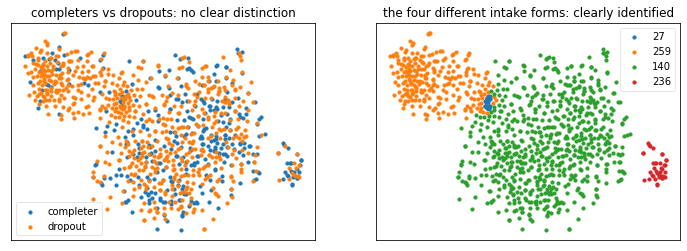

In [48]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
x = [completer_coordinates[i][0] for i in range(0,len(completer_coordinates))]
y = [completer_coordinates[i][1] for i in range(0,len(completer_coordinates))]
ax1.scatter(x,y,s=10,label="completer")
x = [dropout_coordinates[i][0] for i in range(0,len(dropout_coordinates))]
y = [dropout_coordinates[i][1] for i in range(0,len(dropout_coordinates))]
ax1.scatter(x,y,s=10,label="dropout")
ax1.legend(framealpha=0.5)
ax1.title.set_text("completers vs dropouts: no clear distinction")

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
questionnaire_types_list = list(questionnaire_types.values())
for questionnaire_type in set(questionnaire_types.values()):
    x = [all_data_coordinates[i][0] for i in range(0,len(all_data_coordinates)) if questionnaire_types_list[i] == questionnaire_type] 
    y = [all_data_coordinates[i][1] for i in range(0,len(all_data_coordinates)) if questionnaire_types_list[i] == questionnaire_type]
    ax2.scatter(x,y,s=10,label=questionnaire_type)
ax2.legend(framealpha=0.5)
ax2.title.set_text("the four different intake forms: clearly identified")
plt.show()

## Dropout in relation to text

In [21]:
MAILFILE = "emails.csv.gz"

email_data = pd.read_csv(DATADIR+MAILFILE)

In [87]:
def get_longest_mail_per_client(email_data, max_id=None, min_length=None):
    longest_mail_per_client = {}
    current_client = ""
    for i in range(0, len(email_data)):
        if email_data.iloc[i]["Sender"] == "CLIENT":
            client = email_data.iloc[i]["client"]
            mail_body = str(email_data.iloc[i]["Body"])
            if client == current_client:
                mail_id += 1
            else:
                if client < current_client:
                    print("unexpected client order: {current_client} {client}")
                mail_id = 1
                current_client = client
            if max_id == None or mail_id <= max_id:
                if min_length == None or len(mail_body) >= min_length:
                    if not client in longest_mail_per_client or len(longest_mail_per_client[client]["mail_body"]) < len(mail_body):
                        longest_mail_per_client[client] = {"mail_body": mail_body, "mail_id": mail_id }
    return(longest_mail_per_client)

In [31]:
longest_mail_per_client = get_longest_mail_per_client(email_data)

In [68]:
def count_index_longest_mails(longest_mail_per_client):
    counts = Counter([longest_mail_per_client[client]["mail_id"] for client in longest_mail_per_client])
    counts = { x:counts[x] for x in sorted(counts.keys()) }
    return(counts)

def count_mails_with_certain_lengths(longest_mail_per_client, max_id):
    lengths = Counter([len(longest_mails[client]["mail_body"]) for client in longest_mails if longest_mails[client]["mail_id"] <= max_id])
    lengths1000 = {}
    for length in lengths:
        length1000 = int(length/1000)
        if length1000 in lengths1000:
            lengths1000[length1000] += lengths[length]
        else:
            lengths1000[length1000] = lengths[length]
    return(lengths1000)

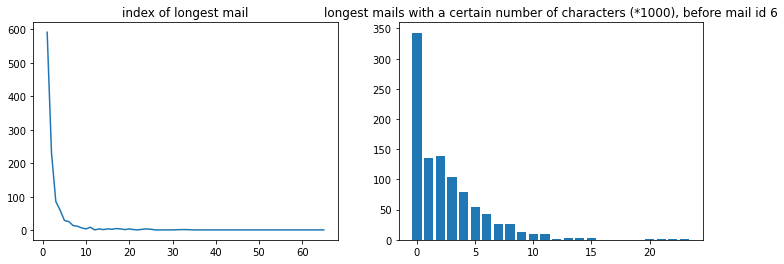

number of mails with 1000-1999 characters: 136


In [91]:
plt.figure(figsize=(12,4))

counts = count_index_longest_mails(longest_mail_per_client)
plt.subplot(121)
plt.plot(counts.keys(), counts.values())
plt.title("index of longest mail")

max_id = 5
lengths1000 = count_mails_with_certain_lengths(longest_mail_per_client, max_id)
plt.subplot(122)
plt.bar(lengths1000.keys(), lengths1000.values())
plt.title(f"longest mails with a certain number of characters (*1000), before mail id {max_id+1}")

plt.show()

print("number of mails with 1000-1999 characters:", lengths1000[1])

In [88]:
selected_mails = get_longest_mail_per_client(email_data, max_id=5, min_length=1000)

In [89]:
len(selected_mails)

749

In [176]:
def compute_token_frequencies(text_list):
    token_frequencies = {}
    token_in_text_counts = {}
    for text in text_list:
        for token in text.lower().split():
            if token in token_frequencies:
                token_frequencies[token] += 1
            else:
                token_frequencies[token] = 1
        for token in set(text.lower().split()):
            if token in token_in_text_counts:
                token_in_text_counts[token] += 1
            else:
                token_in_text_counts[token] = 1
    token_frequencies = { token: token_frequencies[token] for token in sorted(token_frequencies.keys(), key=lambda token: token_frequencies[token], reverse=True) }
    return(token_frequencies, token_in_text_counts)

In [177]:
token_frequencies, token_in_text_counts = compute_token_frequencies([selected_mails[client]['mail_body'] for client in selected_mails.keys()])

In [180]:
def select_tokens(min_frequency, token_in_text_counts, nbr_of_selected_mails):
    selected_tokens = {}
    counter = 0
    for token in token_frequencies:
        if token_in_text_counts[token] < nbr_of_selected_mails:
            if token_frequencies[token] >= MIN_FREQUENCY:
                selected_tokens[token] = counter
                counter += 1
            else:
                break
    return(selected_tokens)

In [181]:
selected_tokens = select_tokens(200, token_in_text_counts, len(selected_mails))

In [193]:
def make_data_from_ids(selected_mails, selected_tokens, ids):
    data = []
    frequencies = len(selected_tokens)*[0]
    for client in ids:
        if client in selected_mails:
            token_list = len(selected_tokens)*[0]
            for token in selected_mails[client]["mail_body"].lower().split():
                if token in selected_tokens:
                    token_list[selected_tokens[token]] = 1
            data.append(token_list)
            for token in set(selected_mails[client]["mail_body"].lower().split()):
                if token in selected_tokens:
                    frequencies[selected_tokens[token]] += 1
    frequencies = [ x/len(ids) for x in frequencies ]
    return(data, frequencies)

In [194]:
dropout_data, dropout_frequencies = make_data_from_ids(selected_mails, selected_tokens, dropout_ids)
completer_data, completer_frequencies = make_data_from_ids(selected_mails, selected_tokens, completer_ids)

In [195]:
results = run_anova_classify(dropout_data, completer_data)

In [196]:
results_per_token = { token: [ results[selected_tokens[token]], dropout_frequencies[selected_tokens[token]], completer_frequencies[selected_tokens[token]] ]
                             for token in sorted(selected_tokens.keys(), key=lambda token: results[selected_tokens[token]]) 
                                                             if results[selected_tokens[token]] <= 0.01 }

In [197]:
results_per_token

{'tot': [2.805084263866283e-06, 0.31852986217457885, 0.6629526462395543],
 'jaren': [6.519174348743807e-06, 0.19142419601837674, 0.4568245125348189],
 'paar': [1.0899615542438701e-05, 0.18223583460949463, 0.4373259052924791],
 'familie': [4.156512086601435e-05, 0.225114854517611, 0.4986072423398329],
 'zeggen': [4.3769705148135975e-05, 0.1225114854517611, 0.3203342618384401],
 '(': [7.408060105884557e-05, 0.4058192955589586, 0.7632311977715878],
 'hem': [8.86903227611265e-05, 0.14548238897396631, 0.3565459610027855],
 'we': [0.00011152783054239525, 0.29555895865237364, 0.6016713091922006],
 'goede': [0.00018398804031828842, 0.1776416539050536, 0.40668523676880225],
 'moeder': [0.00020963705074634152, 0.16539050535987748, 0.38440111420612816],
 'uur': [0.0002483799383021169, 0.17917304747320062, 0.40668523676880225],
 'vooral': [0.00025058087153783656, 0.1332312404287902, 0.32590529247910865],
 'contact': [0.00029998601189485324, 0.2082695252679939, 0.45403899721448465],
 'zeker': [0.00